In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.preprocessing import MinMaxScaler

In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [3]:
df = pd.read_csv(DATASET)

categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

# one hot encoding
df_reg = df.drop(categorical_attr_list, axis=1)
df_reg = df_reg.join(pd.get_dummies(df[categorical_attr_list], columns=categorical_attr_list).astype(int))
df_reg.head()

,frame_count,sum,mean,std,min,max,q01,q05,q25,q75,...,actor_actor_24,actor_actor_3,actor_actor_4,actor_actor_5,actor_actor_6,actor_actor_7,actor_actor_8,actor_actor_9,sex_F,sex_M
0,160160,0.114319,7.137790e-07,0.004283,-0.042603,0.048157,-0.013550,-0.006104,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
1,156956,0.149963,9.554485e-07,0.005084,-0.037018,0.058472,-0.015822,-0.007294,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
2,152152,0.139618,9.176213e-07,0.004886,-0.036652,0.062683,-0.014923,-0.006714,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
3,169769,0.137665,8.108948e-07,0.002956,-0.026245,0.026215,-0.009399,-0.004364,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
4,172972,0.140289,8.110521e-07,0.003085,-0.032349,0.028961,-0.008942,-0.004242,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
features_to_correct = ['stft_min', 'sc_min']
(df[features_to_correct] < 0).any()

stft_min    False
sc_min      False
dtype: bool

# stft_min

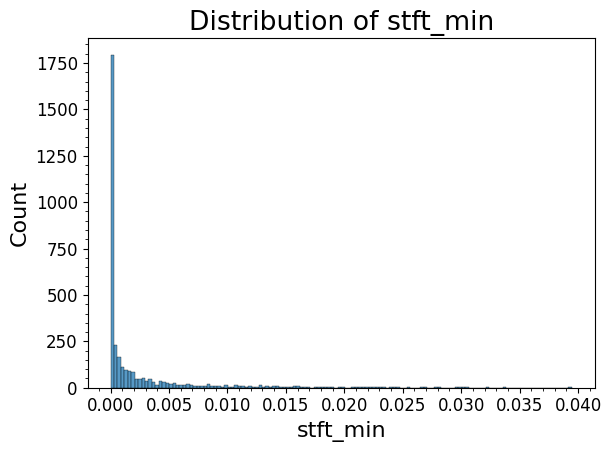

In [5]:
sns.histplot(data=df, x=df['stft_min'], stat='density')
plt.xlabel('stft_min')
plt.ylabel('Count')
plt.title('Distribution of stft_min')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

# rows to be fixed, do not reset indexes!
df_zero = df_reg[df_reg['stft_min'] == 0]
df_nz = df_reg[df_reg['stft_min'] != 0].reset_index(drop=True)

# dataframe has been one hot encoded
split_index = df_nz.index[df_nz['actor_actor_19'] == 1][0]

df_train = df_nz[:split_index]
df_test = df_nz[split_index:]

df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=100)

y_train = np.log10(df_train['stft_min'].to_numpy())
y_valid = np.log10(df_valid['stft_min'].to_numpy())
y_test = np.log10(df_test['stft_min'].to_numpy())

df_zero = df_zero.drop(['stft_min'], axis=1)
df_train = df_train.drop(['stft_min'], axis=1)
df_valid = df_valid.drop(['stft_min'], axis=1)
df_test = df_test.drop(['stft_min'], axis=1)

X_to_pred = df_zero.to_numpy()
X_train = df_train.to_numpy()
X_valid = df_valid.to_numpy()
X_test = df_test.to_numpy()

print(X_train.shape, X_valid.shape, X_test.shape, X_to_pred.shape)

(793, 284) (265, 284) (362, 284) (1009, 284)


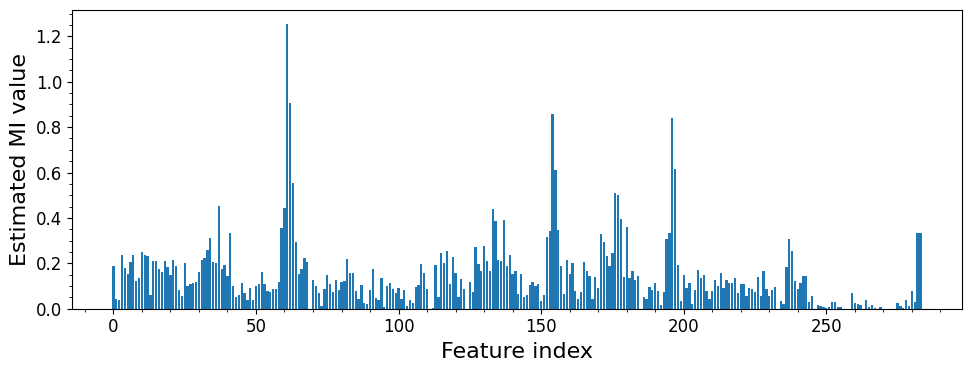

In [7]:
f_selector = SelectKBest(score_func=mutual_info_regression, k='all')
f_selector.fit(X_train, y_train)

plt.figure(figsize=(10, 4))
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel('Feature index')
plt.ylabel('Estimated MI value')
plt.show()

In [8]:
f_selector = SelectKBest(score_func=mutual_info_regression, k=20)
f_selector.fit(X_train, y_train)

X_train = f_selector.transform(X_train)
X_valid = f_selector.transform(X_valid)
X_test = f_selector.transform(X_test)
X_to_pred = f_selector.transform(X_to_pred)

# selected columns
selected_indices = f_selector.get_support(indices=True)
df_reg.iloc[:, selected_indices]

,mfcc_q25,mfcc_q99,stft_mean,stft_std,stft_min,stft_q01,stft_q05,mfcc_q05_w2,mfcc_q25_w2,mfcc_q95_w2,stft_sum_w2,stft_std_w2,stft_q05_w2,stft_q25_w2,mfcc_q05_w3,mfcc_q25_w3,mfcc_q50_w3,mfcc_q95_w3,stft_std_w3,stft_q01_w3
0,-3.248759,165.340459,0.629568,0.277748,0.008878,0.048266,0.116556,-120.117107,-11.527863,52.003055,484.868805,0.293215,0.069133,0.261142,-67.755763,-9.989349,-0.172550,62.708651,0.290738,0.047669
1,-2.454553,175.846084,0.619984,0.279639,0.000000,0.039225,0.103585,-75.363458,-11.434454,48.559144,468.430938,0.302636,0.063778,0.239860,-71.935123,-9.649912,-0.237159,63.767483,0.285455,0.046734
2,-2.546799,165.640911,0.612607,0.263994,0.032363,0.058727,0.152042,-68.998278,-10.588931,47.860892,478.721360,0.293498,0.099196,0.268918,-69.634357,-8.167052,0.444741,63.596519,0.280918,0.049062
3,-3.493539,167.973568,0.608243,0.293414,0.000000,0.011911,0.097330,-83.044930,-10.651319,56.442131,480.684962,0.293618,0.074663,0.222230,-65.700882,-11.507271,-0.839454,69.896139,0.290291,0.046423
4,-2.329377,167.472222,0.644044,0.271359,0.000000,0.063752,0.148925,-73.239906,-10.560717,59.259329,527.873676,0.281825,0.085910,0.288242,-64.224837,-9.563899,0.129829,62.749889,0.274131,0.069192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,-14.566319,122.559663,0.380013,0.358211,0.000000,0.000000,0.000000,-99.759052,-20.961018,45.060317,392.845148,0.334506,0.000275,0.013865,-94.788390,-22.633643,-11.140555,56.190917,0.318587,0.000218
2425,-16.516638,108.475085,0.384475,0.342570,0.000000,0.000000,0.000535,-94.174167,-21.225479,49.527611,391.581885,0.327351,0.002639,0.026575,-129.524864,-25.793420,-12.820762,56.286695,0.319367,0.000418
2426,-15.071037,111.296732,0.379459,0.343235,0.000000,0.000000,0.000000,-95.961729,-21.014818,52.465301,387.840356,0.329636,0.005785,0.031443,-84.901732,-23.546573,-12.323875,55.225316,0.318763,0.000521
2427,-14.316145,113.483748,0.393004,0.353190,0.000000,0.000000,0.000000,-104.770460,-21.403561,51.408106,397.483970,0.340376,0.004331,0.028292,-84.443920,-23.132294,-10.467500,62.430943,0.321830,0.000820


In [9]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)
X_to_pred = scaler.fit_transform(X_to_pred)

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
    gamma = trial.suggest_float('gamma', 0, 5)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 3)
    subsample = trial.suggest_float('subsample', 0.4, 1)

    xgb = XGBRegressor(booster=booster, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, subsample=subsample)

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_valid)

    error = mean_squared_error(y_valid, y_pred)

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials=150, n_jobs=-1)

[I 2023-06-04 17:53:04,081] A new study created in memory with name: no-name-0f74e819-3d34-438a-8e5b-d01d70e4ee0b
[I 2023-06-04 17:53:08,270] Trial 1 finished with value: 0.05469547707760329 and parameters: {'booster': 'gbtree', 'gamma': 2.3906846452986636, 'max_depth': 12, 'min_child_weight': 3, 'subsample': 0.783030285940578}. Best is trial 1 with value: 0.05469547707760329.
[I 2023-06-04 17:53:09,435] Trial 4 finished with value: 0.060744574218685767 and parameters: {'booster': 'gbtree', 'gamma': 0.33116535482111353, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.48743078998891987}. Best is trial 1 with value: 0.05469547707760329.
[I 2023-06-04 17:53:11,385] Trial 5 finished with value: 0.0580533821256623 and parameters: {'booster': 'gbtree', 'gamma': 2.3405164121389905, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.5442301255506048}. Best is trial 1 with value: 0.05469547707760329.
[I 2023-06-04 17:53:11,400] Trial 3 finished with value: 0.05809329646568329 and param

[I 2023-06-04 17:54:04,879] Trial 32 finished with value: 0.053757051317027696 and parameters: {'booster': 'dart', 'gamma': 3.32976854370728, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.6155459282330382}. Best is trial 27 with value: 0.05349504157120325.
[I 2023-06-04 17:54:05,343] Trial 31 finished with value: 0.05467554670874192 and parameters: {'booster': 'dart', 'gamma': 3.4751709283725734, 'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.6149166076397276}. Best is trial 27 with value: 0.05349504157120325.
[I 2023-06-04 17:54:05,655] Trial 33 finished with value: 0.057990900870309024 and parameters: {'booster': 'dart', 'gamma': 3.3330532017701033, 'max_depth': 14, 'min_child_weight': 2, 'subsample': 0.6050687858114239}. Best is trial 27 with value: 0.05349504157120325.
[I 2023-06-04 17:54:09,231] Trial 34 finished with value: 0.05841554895857638 and parameters: {'booster': 'dart', 'gamma': 3.9005182384350263, 'max_depth': 15, 'min_child_weight': 3, 'subsample': 0.5

[I 2023-06-04 17:54:52,989] Trial 61 finished with value: 0.057961561490092135 and parameters: {'booster': 'gbtree', 'gamma': 3.774605418676369, 'max_depth': 11, 'min_child_weight': 3, 'subsample': 0.6824312029737201}. Best is trial 27 with value: 0.05349504157120325.
[I 2023-06-04 17:54:54,707] Trial 64 finished with value: 0.05553516297720956 and parameters: {'booster': 'dart', 'gamma': 3.063671766006202, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.6646126309815925}. Best is trial 27 with value: 0.05349504157120325.
[I 2023-06-04 17:54:55,526] Trial 63 finished with value: 0.05678853658274723 and parameters: {'booster': 'dart', 'gamma': 4.024910530039234, 'max_depth': 18, 'min_child_weight': 3, 'subsample': 0.547677819091708}. Best is trial 27 with value: 0.05349504157120325.
[I 2023-06-04 17:54:56,468] Trial 65 finished with value: 0.05685387756542877 and parameters: {'booster': 'dart', 'gamma': 3.2827680279484506, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.6593

[I 2023-06-04 17:55:29,516] Trial 92 finished with value: 0.05317580881894549 and parameters: {'booster': 'dart', 'gamma': 3.883745241182794, 'max_depth': 12, 'min_child_weight': 3, 'subsample': 0.7310863820265738}. Best is trial 92 with value: 0.05317580881894549.
[I 2023-06-04 17:55:32,623] Trial 94 finished with value: 0.0584314697797569 and parameters: {'booster': 'dart', 'gamma': 3.311461524572898, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.6909445066792815}. Best is trial 92 with value: 0.05317580881894549.
[I 2023-06-04 17:55:32,807] Trial 95 finished with value: 0.05381362176553817 and parameters: {'booster': 'dart', 'gamma': 3.7131412446784227, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.7237320035741778}. Best is trial 92 with value: 0.05317580881894549.
[I 2023-06-04 17:55:34,725] Trial 97 finished with value: 0.05878129932747021 and parameters: {'booster': 'dart', 'gamma': 3.8878515148813246, 'max_depth': 15, 'min_child_weight': 3, 'subsample': 0.7474

[I 2023-06-04 17:56:13,653] Trial 124 finished with value: 0.05654156888709439 and parameters: {'booster': 'dart', 'gamma': 3.6665806031238097, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.7389764018820727}. Best is trial 92 with value: 0.05317580881894549.
[I 2023-06-04 17:56:14,456] Trial 125 finished with value: 0.05672672755587854 and parameters: {'booster': 'dart', 'gamma': 3.649546977856417, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.7005398596165886}. Best is trial 92 with value: 0.05317580881894549.
[I 2023-06-04 17:56:15,539] Trial 126 finished with value: 0.056729784361624416 and parameters: {'booster': 'dart', 'gamma': 3.6880239488423956, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.7001147686170218}. Best is trial 92 with value: 0.05317580881894549.
[I 2023-06-04 17:56:16,196] Trial 127 finished with value: 0.056724145808367925 and parameters: {'booster': 'dart', 'gamma': 3.618574558615801, 'max_depth': 11, 'min_child_weight': 2, 'subsample':

In [11]:
best_params = study.best_params

xgb = XGBRegressor(**best_params)
xgb.fit(X_train, y_train)

y_pred_test = xgb.predict(X_test)

print(best_params)
print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

{'booster': 'dart', 'gamma': 3.8614496513661845, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.7313429121788284}
Root mean squared error = 0.2999
R-squared = 0.8031


In [12]:
y_pred = xgb.predict(X_to_pred)
y_pred = np.power(10, y_pred)
y_pred

array([1.2835833e-02, 2.6897478e-03, 1.2835833e-02, ..., 8.4187050e-05,
       8.4187050e-05, 5.9930906e-05], dtype=float32)

In [13]:
# negative values predicted
np.count_nonzero(y_pred < 0)

0

In [14]:
df_zero['stft_min'] = y_pred
df.update(df_zero)

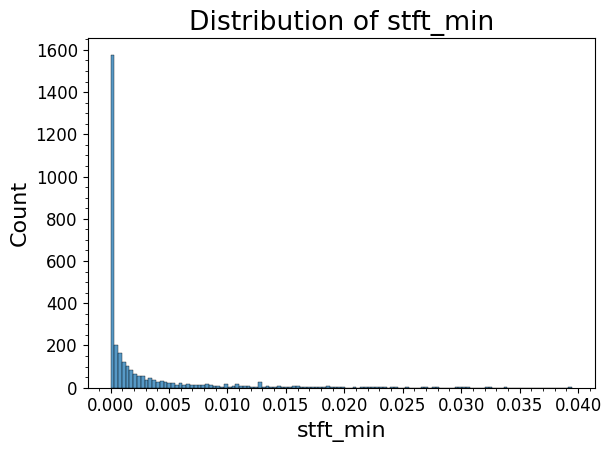

In [15]:
sns.histplot(data=df, x='stft_min', stat='density')
plt.xlabel('stft_min')
plt.ylabel('Count')
plt.title('Distribution of stft_min')
plt.show()

In [16]:
df['stft_min'].corr(df['stft_q01'], method='spearman')

0.9199475307494182

# frame_count

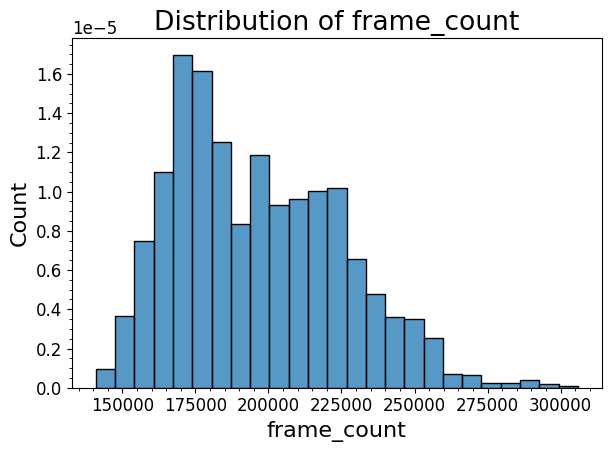

In [17]:
sns.histplot(data=df, x=df['frame_count'], stat='density')
plt.xlabel('frame_count')
plt.ylabel('Count')
plt.title('Distribution of frame_count')
plt.show()

In [18]:
from sklearn.model_selection import train_test_split

# dataframe has been one hot encoded
split_index = df_reg.index[df_reg['actor_actor_19'] == 1][0]

df_train = df_reg[:split_index]
df_test = df_reg[split_index:]

df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=100)

y_train = df_train['frame_count'].to_numpy()
y_valid = df_valid['frame_count'].to_numpy()
y_test = df_test['frame_count'].to_numpy()

df_train = df_train.drop(['frame_count'], axis=1)
df_valid = df_valid.drop(['frame_count'], axis=1)
df_test = df_test.drop(['frame_count'], axis=1)

X_train = df_train.to_numpy()
X_valid = df_valid.to_numpy()
X_test = df_test.to_numpy()

print(X_train.shape, X_valid.shape, X_test.shape)

(1357, 284) (453, 284) (619, 284)


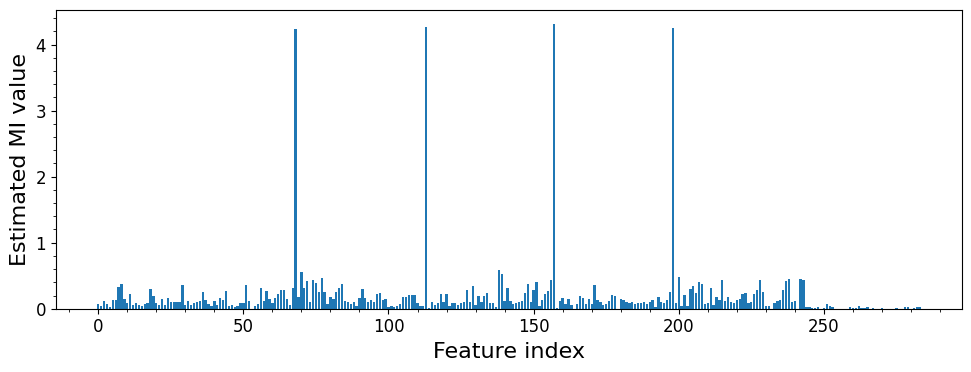

In [19]:
f_selector = SelectKBest(score_func=mutual_info_regression, k='all')
f_selector.fit(X_train, y_train)

plt.figure(figsize=(10, 4))
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel('Feature index')
plt.ylabel('Estimated MI value')
plt.show()

In [20]:
f_selector = SelectKBest(score_func=mutual_info_regression, k=4)
f_selector.fit(X_train, y_train)

X_train = f_selector.transform(X_train)
X_valid = f_selector.transform(X_valid)
X_test = f_selector.transform(X_test)

# selected columns
selected_indices = f_selector.get_support(indices=True)
df_reg.iloc[:, selected_indices]

,stft_skew,stft_skew_w1,stft_skew_w2,stft_q25_w3
0,-0.492174,-0.561529,0.155481,0.209817
1,-0.473775,-0.280715,0.128863,0.221506
2,-0.269943,-0.205140,0.096396,0.295453
3,-0.414662,-1.838410,0.303969,0.189045
4,-0.457552,-0.729845,0.164317,0.257204
...,...,...,...,...
2424,0.411823,0.320232,0.936319,0.009999
2425,0.460356,0.154591,0.940912,0.010816
2426,0.506281,0.107261,0.879905,0.009420
2427,0.375856,0.201044,0.769979,0.012667


In [21]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)

In [22]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
    gamma = trial.suggest_float('gamma', 0, 5)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 3)
    subsample = trial.suggest_float('subsample', 0.4, 1)

    xgb = XGBRegressor(booster=booster, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, subsample=subsample)

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_valid)

    error = mean_squared_error(y_valid, y_pred)

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials=150, n_jobs=-1)

[I 2023-06-04 17:58:08,412] A new study created in memory with name: no-name-9d54df08-01d6-46c2-be85-b0467fb0d5f3
[I 2023-06-04 17:58:08,774] Trial 0 finished with value: 7770213.227695355 and parameters: {'booster': 'gbtree', 'gamma': 3.910412776583501, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.7707159336164165}. Best is trial 0 with value: 7770213.227695355.
[I 2023-06-04 17:58:08,829] Trial 1 finished with value: 7574863.088712512 and parameters: {'booster': 'gbtree', 'gamma': 1.827239043575764, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.506055904827282}. Best is trial 1 with value: 7574863.088712512.
[I 2023-06-04 17:58:09,280] Trial 3 finished with value: 7601516.833207221 and parameters: {'booster': 'gbtree', 'gamma': 0.8125218142189555, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.5835242959957101}. Best is trial 1 with value: 7574863.088712512.
[I 2023-06-04 17:58:09,667] Trial 5 finished with value: 7593803.523071558 and parameters: {'booster':

[I 2023-06-04 17:58:22,859] Trial 30 finished with value: 7507693.312837377 and parameters: {'booster': 'dart', 'gamma': 1.289276965353836, 'max_depth': 16, 'min_child_weight': 2, 'subsample': 0.4635002692448064}. Best is trial 30 with value: 7507693.312837377.
[I 2023-06-04 17:58:23,418] Trial 31 finished with value: 7522122.436683503 and parameters: {'booster': 'dart', 'gamma': 0.032447828312475835, 'max_depth': 17, 'min_child_weight': 2, 'subsample': 0.4539865552153106}. Best is trial 30 with value: 7507693.312837377.
[I 2023-06-04 17:58:26,122] Trial 35 finished with value: 7497072.31428282 and parameters: {'booster': 'dart', 'gamma': 1.1798076020517794, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.44960369476172835}. Best is trial 35 with value: 7497072.31428282.
[I 2023-06-04 17:58:26,179] Trial 33 finished with value: 7484331.300732207 and parameters: {'booster': 'dart', 'gamma': 1.3153252958397883, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.450784862253738

[I 2023-06-04 17:58:48,353] Trial 62 finished with value: 7560438.152065117 and parameters: {'booster': 'dart', 'gamma': 0.6827026457665772, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.5823832755016498}. Best is trial 43 with value: 7448992.454590383.
[I 2023-06-04 17:58:48,763] Trial 64 finished with value: 7447551.504080328 and parameters: {'booster': 'dart', 'gamma': 0.674257080908596, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.5377382711687649}. Best is trial 64 with value: 7447551.504080328.
[I 2023-06-04 17:58:49,902] Trial 65 finished with value: 7506904.656869783 and parameters: {'booster': 'dart', 'gamma': 0.7603834565372338, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.5035762857946672}. Best is trial 64 with value: 7447551.504080328.
[I 2023-06-04 17:58:51,215] Trial 66 finished with value: 7438227.048517695 and parameters: {'booster': 'dart', 'gamma': 0.2174150425894803, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.5387793062216654}. B

[I 2023-06-04 17:59:10,092] Trial 95 finished with value: 7486826.75930483 and parameters: {'booster': 'dart', 'gamma': 0.5294342169754316, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.5120733789568336}. Best is trial 87 with value: 7418136.0666083535.
[I 2023-06-04 17:59:10,359] Trial 96 finished with value: 7523117.287892457 and parameters: {'booster': 'dart', 'gamma': 0.02775428662953988, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.5099570856414543}. Best is trial 87 with value: 7418136.0666083535.
[I 2023-06-04 17:59:11,184] Trial 97 finished with value: 7520864.949563673 and parameters: {'booster': 'dart', 'gamma': 0.04982729543445363, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.5094689005554899}. Best is trial 87 with value: 7418136.0666083535.
[I 2023-06-04 17:59:12,218] Trial 98 finished with value: 7481190.817180709 and parameters: {'booster': 'dart', 'gamma': 0.12738823565726903, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.51024898285919

[I 2023-06-04 17:59:31,131] Trial 128 finished with value: 7494991.661698163 and parameters: {'booster': 'dart', 'gamma': 0.4531085053463991, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.5458344165443316}. Best is trial 87 with value: 7418136.0666083535.
[I 2023-06-04 17:59:31,359] Trial 127 finished with value: 7454872.541696308 and parameters: {'booster': 'dart', 'gamma': 0.21572844910135647, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.4668948422795626}. Best is trial 87 with value: 7418136.0666083535.
[I 2023-06-04 17:59:32,558] Trial 129 finished with value: 7454045.845575934 and parameters: {'booster': 'dart', 'gamma': 0.45385999590332615, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.5481627326605087}. Best is trial 87 with value: 7418136.0666083535.
[I 2023-06-04 17:59:32,754] Trial 130 finished with value: 7432651.801987402 and parameters: {'booster': 'dart', 'gamma': 0.4092341428307837, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.4676975442

In [23]:
best_params = study.best_params

xgb = XGBRegressor(**best_params)
xgb.fit(X_train, y_train)

y_pred_test = xgb.predict(X_test)

print(best_params)
print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

{'booster': 'dart', 'gamma': 0.40748513516996004, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.5449746316148342}
Root mean squared error = 9281.4880
R-squared = 0.8963


In [24]:
pd.DataFrame({'test' : y_test, 'pred': y_pred_test})

,test,pred
0,161762,155352.093750
1,155355,148946.375000
2,160160,153753.718750
3,158558,152157.406250
4,176176,168167.359375
...,...,...
614,219419,209811.953125
615,217817,208202.968750
616,206606,197002.203125
617,203404,193790.218750


In [25]:
from keras.layers import Dense
from keras import Input, Model

# objective function to be minimized
def objective_fun(trial):

    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'elu'])
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'adagrad'])
    loss = trial.suggest_categorical('loss', ['mean_squared_error'])
    units = trial.suggest_int('units', 32, 64, step=32)
    epochs = trial.suggest_int('epochs', 3, 7)
    batch_size = trial.suggest_int('batch_size', 64, 128, step=64)


    input_layer = Input(shape=(X_train.shape[1]), name='input')
    hidden_layer = Dense(units=units, activation=activation)(input_layer)
    #hidden_layer = Dense(units=units, activation=activation)(hidden_layer)
    output_layer = Dense(1, name='output')(hidden_layer)

    ann = Model(inputs=input_layer, outputs=output_layer, name='DenseNetwork')

    ann.compile(optimizer=optimizer, loss=loss)

    ann.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=False)

    y_pred = ann.predict(X_valid)

    error = mean_squared_error(y_valid, y_pred)

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials=150, n_jobs=-1)

2023-06-04 18:00:32.944302: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-04 18:00:33.329025: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-04 18:00:33.331461: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 18:00:35.708056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[I 2023-06-04 18:00:37,851] A new study created in memory with name: no-name-d7a9814e-f979-47b3-aec8-f699867a4fe2


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 18:00:42,930] Trial 0 finished with value: 39037439431.31526 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 3, 'batch_size': 64}. Best is trial 0 with value: 39037439431.31526.
[I 2023-06-04 18:00:42,979] Trial 2 finished with value: 39037954440.46 and parameters: {'activation': 'tanh', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 4, 'batch_size': 64}. Best is trial 0 with value: 39037439431.31526.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 18:00:43,354] Trial 1 finished with value: 39037220771.64563 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 128}. Best is trial 1 with value: 39037220771.64563.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 18:00:44,217] Trial 3 finished with value: 39037426698.34717 and parameters: {'activation': 'relu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 5, 'batch_size': 64}. Best is trial 1 with value: 39037220771.64563.


15/15 [==============================] - 0s 5ms/step


[I 2023-06-04 18:00:47,203] Trial 5 finished with value: 39037798908.69579 and parameters: {'activation': 'tanh', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 128}. Best is trial 1 with value: 39037220771.64563.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 18:00:48,033] Trial 4 finished with value: 39036471990.3095 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 6, 'batch_size': 64}. Best is trial 4 with value: 39036471990.3095.


15/15 [==============================] - 0s 9ms/step


[I 2023-06-04 18:00:48,621] Trial 7 finished with value: 39037684962.723755 and parameters: {'activation': 'relu', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 128}. Best is trial 4 with value: 39036471990.3095.


15/15 [==============================] - 0s 9ms/step


[I 2023-06-04 18:00:49,356] Trial 6 finished with value: 39034556758.93041 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 6 with value: 39034556758.93041.


 1/15 [=>............................] - ETA: 2s

[I 2023-06-04 18:00:52,280] Trial 10 finished with value: 39037342433.50119 and parameters: {'activation': 'elu', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 4, 'batch_size': 128}. Best is trial 6 with value: 39034556758.93041.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 18:00:52,478] Trial 8 finished with value: 39036498596.38024 and parameters: {'activation': 'elu', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 6, 'batch_size': 64}. Best is trial 6 with value: 39034556758.93041.


15/15 [==============================] - 0s 9ms/step


[I 2023-06-04 18:00:53,369] Trial 9 finished with value: 39037596693.14473 and parameters: {'activation': 'relu', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 128}. Best is trial 6 with value: 39034556758.93041.


15/15 [==============================] - 0s 17ms/step


[I 2023-06-04 18:00:54,073] Trial 11 finished with value: 39037130425.04562 and parameters: {'activation': 'relu', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 5, 'batch_size': 64}. Best is trial 6 with value: 39034556758.93041.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 18:00:56,640] Trial 12 finished with value: 39037609414.76743 and parameters: {'activation': 'relu', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 4, 'batch_size': 128}. Best is trial 6 with value: 39034556758.93041.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 18:00:58,214] Trial 13 finished with value: 39035681368.02192 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 6 with value: 39034556758.93041.


15/15 [==============================] - 0s 9ms/step


[I 2023-06-04 18:00:59,378] Trial 14 finished with value: 39035714063.43443 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 6 with value: 39034556758.93041.


15/15 [==============================] - 0s 8ms/step


[I 2023-06-04 18:00:59,995] Trial 15 finished with value: 39035387727.00015 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 6 with value: 39034556758.93041.


15/15 [==============================] - 0s 5ms/step


[I 2023-06-04 18:01:02,343] Trial 16 finished with value: 39035408363.72632 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 6 with value: 39034556758.93041.


15/15 [==============================] - 0s 8ms/step


[I 2023-06-04 18:01:04,258] Trial 17 finished with value: 39035373327.73625 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 6 with value: 39034556758.93041.


15/15 [==============================] - 0s 8ms/step


[I 2023-06-04 18:01:04,617] Trial 18 finished with value: 39034682536.53483 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 6 with value: 39034556758.93041.


15/15 [==============================] - 0s 8ms/step


[I 2023-06-04 18:01:05,972] Trial 19 finished with value: 39034841558.89597 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 6 with value: 39034556758.93041.


15/15 [==============================] - 0s 9ms/step


[I 2023-06-04 18:01:08,112] Trial 20 finished with value: 39034468335.86221 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 18:01:09,213] Trial 21 finished with value: 39037696097.79927 and parameters: {'activation': 'elu', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.
[I 2023-06-04 18:01:09,240] Trial 22 finished with value: 39037720980.99232 and parameters: {'activation': 'elu', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 1s 9ms/step


[I 2023-06-04 18:01:11,835] Trial 23 finished with value: 39037777263.03713 and parameters: {'activation': 'tanh', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 18:01:14,244] Trial 24 finished with value: 39037700936.84984 and parameters: {'activation': 'elu', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 18:01:14,662] Trial 25 finished with value: 39034501447.33413 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 8ms/step


[I 2023-06-04 18:01:16,018] Trial 26 finished with value: 39034895826.1262 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 9ms/step


[I 2023-06-04 18:01:17,239] Trial 27 finished with value: 39036042573.62669 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 5, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 8ms/step


[I 2023-06-04 18:01:19,296] Trial 28 finished with value: 39036122918.624535 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 5, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 18:01:19,492] Trial 29 finished with value: 39036338034.03105 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 5, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 18:01:21,671] Trial 30 finished with value: 39036286874.70227 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 5, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 18:01:23,262] Trial 31 finished with value: 39036382557.44781 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 5, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 18:01:24,314] Trial 32 finished with value: 39037017277.32104 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 3, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 13ms/step


[I 2023-06-04 18:01:24,912] Trial 33 finished with value: 39037180875.5992 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 3, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 9ms/step


[I 2023-06-04 18:01:27,714] Trial 34 finished with value: 39035123014.55246 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 5ms/step


[I 2023-06-04 18:01:29,403] Trial 35 finished with value: 39034561465.350586 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 18:01:30,382] Trial 36 finished with value: 39035090846.38036 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 18:01:30,942] Trial 37 finished with value: 39034751894.86812 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 18:01:33,778] Trial 38 finished with value: 39034935045.697914 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 18:01:35,572] Trial 39 finished with value: 39034562275.01093 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 8ms/step


[I 2023-06-04 18:01:35,942] Trial 40 finished with value: 39037130714.844215 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 128}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 14ms/step


[I 2023-06-04 18:01:36,386] Trial 41 finished with value: 39037186891.12743 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 128}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 5ms/step


[I 2023-06-04 18:01:40,374] Trial 42 finished with value: 39037343591.546616 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 6, 'batch_size': 128}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 18:01:40,879] Trial 43 finished with value: 39037466180.72349 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 6, 'batch_size': 128}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 8ms/step


[I 2023-06-04 18:01:41,872] Trial 45 finished with value: 39035401390.42984 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.
[I 2023-06-04 18:01:42,027] Trial 44 finished with value: 39035795485.98808 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


 9/15 [=================>............] - ETA: 0s

[I 2023-06-04 18:01:46,044] Trial 47 finished with value: 39034705800.31255 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 13ms/step


[I 2023-06-04 18:01:46,275] Trial 46 finished with value: 39034686173.05674 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 18:01:46,976] Trial 49 finished with value: 39037238847.27922 and parameters: {'activation': 'relu', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.
[I 2023-06-04 18:01:47,041] Trial 48 finished with value: 39034834623.7176 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


 1/15 [=>............................] - ETA: 2s

[I 2023-06-04 18:01:51,002] Trial 50 finished with value: 39036533052.0099 and parameters: {'activation': 'relu', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 15ms/step


[I 2023-06-04 18:01:51,251] Trial 51 finished with value: 39036694891.01141 and parameters: {'activation': 'relu', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 18:01:51,667] Trial 52 finished with value: 39037864453.830956 and parameters: {'activation': 'relu', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 11ms/step


[I 2023-06-04 18:01:52,954] Trial 53 finished with value: 39036934282.21452 and parameters: {'activation': 'relu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 18:01:56,932] Trial 56 finished with value: 39035390976.50259 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 9ms/step


[I 2023-06-04 18:01:57,176] Trial 54 finished with value: 39034818678.99412 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.
[I 2023-06-04 18:01:57,276] Trial 55 finished with value: 39034782629.3086 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 18:01:58,999] Trial 57 finished with value: 39035123633.45906 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 18:02:03,142] Trial 58 finished with value: 39034531052.249725 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.
[I 2023-06-04 18:02:03,174] Trial 59 finished with value: 39034701729.67135 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39034468335.86221.
[I 2023-06-04 18:02:03,176] Trial 60 finished with value: 39034331712.90225 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 8ms/step


[I 2023-06-04 18:02:06,890] Trial 61 finished with value: 39035010065.594025 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 18:02:08,993] Trial 62 finished with value: 39036469556.94146 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 4, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 8ms/step


[I 2023-06-04 18:02:09,205] Trial 64 finished with value: 39034553431.34004 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.
[I 2023-06-04 18:02:09,266] Trial 63 finished with value: 39035057473.07069 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 18:02:12,725] Trial 65 finished with value: 39035041289.02709 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 5ms/step


[I 2023-06-04 18:02:13,972] Trial 68 finished with value: 39037780791.83671 and parameters: {'activation': 'elu', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.
[I 2023-06-04 18:02:14,032] Trial 67 finished with value: 39037637030.413506 and parameters: {'activation': 'elu', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 18:02:14,583] Trial 66 finished with value: 39034861410.03618 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 14ms/step


[I 2023-06-04 18:02:17,688] Trial 69 finished with value: 39037755235.489845 and parameters: {'activation': 'elu', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


 1/15 [=>............................] - ETA: 3s

[I 2023-06-04 18:02:20,045] Trial 70 finished with value: 39035601900.943405 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 18:02:20,167] Trial 72 finished with value: 39035491546.22194 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.
[I 2023-06-04 18:02:20,281] Trial 71 finished with value: 39035609835.37435 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 18:02:23,110] Trial 73 finished with value: 39036552212.053696 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 4, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 3ms/step


[I 2023-06-04 18:02:26,308] Trial 75 finished with value: 39034878230.64074 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.
[I 2023-06-04 18:02:26,336] Trial 74 finished with value: 39034907524.530525 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 5ms/step


[I 2023-06-04 18:02:29,577] Trial 77 finished with value: 39034848428.803375 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.
[I 2023-06-04 18:02:29,578] Trial 76 finished with value: 39034602053.32609 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


11/15 [=====================>........] - ETA: 0s

[I 2023-06-04 18:02:30,579] Trial 79 finished with value: 39035069454.66495 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 11ms/step


[I 2023-06-04 18:02:30,721] Trial 78 finished with value: 39034696543.60122 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 18:02:35,705] Trial 80 finished with value: 39034452814.09575 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


 8/15 [===============>..............] - ETA: 0s

[I 2023-06-04 18:02:36,304] Trial 81 finished with value: 39034874473.36561 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


 9/15 [=================>............] - ETA: 0s

[I 2023-06-04 18:02:36,473] Trial 82 finished with value: 39034572280.15565 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 8ms/step


[I 2023-06-04 18:02:36,684] Trial 83 finished with value: 39034952274.75428 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 18:02:41,488] Trial 84 finished with value: 39035108728.07687 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - ETA: 0s

[I 2023-06-04 18:02:42,379] Trial 86 finished with value: 39034748607.10522 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


 8/15 [===============>..............] - ETA: 0s

[I 2023-06-04 18:02:42,519] Trial 85 finished with value: 39034481181.85234 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 9ms/step


[I 2023-06-04 18:02:42,691] Trial 87 finished with value: 39034697112.97153 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 18:02:47,307] Trial 88 finished with value: 39034666752.43223 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 5ms/step


[I 2023-06-04 18:02:48,538] Trial 90 finished with value: 39034707711.70473 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 5ms/step


[I 2023-06-04 18:02:48,935] Trial 91 finished with value: 39035160921.38553 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 9ms/step


[I 2023-06-04 18:02:50,222] Trial 89 finished with value: 39034722158.26772 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 18:02:54,271] Trial 92 finished with value: 39034387447.84274 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.
[I 2023-06-04 18:02:54,303] Trial 93 finished with value: 39034696879.21366 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 18ms/step


[I 2023-06-04 18:02:54,744] Trial 94 finished with value: 39034669251.41923 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 13ms/step


[I 2023-06-04 18:02:56,121] Trial 95 finished with value: 39034778385.44831 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 18:03:00,385] Trial 96 finished with value: 39034751728.65086 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


 7/15 [=============>................] - ETA: 0s

[I 2023-06-04 18:03:00,540] Trial 98 finished with value: 39034728432.815796 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 14ms/step


[I 2023-06-04 18:03:00,700] Trial 97 finished with value: 39034929412.44868 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 11ms/step


[I 2023-06-04 18:03:02,164] Trial 99 finished with value: 39034820779.26313 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 18:03:05,232] Trial 102 finished with value: 39036703741.94686 and parameters: {'activation': 'elu', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 128}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 18:03:05,936] Trial 101 finished with value: 39036431030.39183 and parameters: {'activation': 'elu', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 8ms/step


[I 2023-06-04 18:03:06,354] Trial 100 finished with value: 39034817495.16811 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.
[I 2023-06-04 18:03:06,376] Trial 103 finished with value: 39037090237.24134 and parameters: {'activation': 'elu', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 128}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 18:03:11,408] Trial 104 finished with value: 39036138351.03579 and parameters: {'activation': 'relu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 4ms/step


[I 2023-06-04 18:03:11,740] Trial 105 finished with value: 39036441109.19896 and parameters: {'activation': 'relu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 18:03:12,602] Trial 106 finished with value: 39037056898.11886 and parameters: {'activation': 'relu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.
[I 2023-06-04 18:03:12,622] Trial 107 finished with value: 39036855289.47296 and parameters: {'activation': 'relu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 9ms/step


[I 2023-06-04 18:03:17,263] Trial 111 finished with value: 39037632661.09053 and parameters: {'activation': 'tanh', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 18:03:17,731] Trial 109 finished with value: 39034655747.27275 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 8ms/step


[I 2023-06-04 18:03:18,545] Trial 110 finished with value: 39034902600.12624 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 9ms/step


[I 2023-06-04 18:03:20,904] Trial 108 finished with value: 39034788672.170334 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 18:03:22,298] Trial 112 finished with value: 39036985411.5322 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 3, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 18:03:22,778] Trial 113 finished with value: 39037083301.46239 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 3, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 13ms/step


[I 2023-06-04 18:03:24,124] Trial 114 finished with value: 39034876579.665955 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 18:03:26,805] Trial 115 finished with value: 39035030061.58692 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 18:03:28,423] Trial 116 finished with value: 39034855056.144005 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 9ms/step


[I 2023-06-04 18:03:28,785] Trial 117 finished with value: 39034866726.413826 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 18:03:30,003] Trial 118 finished with value: 39034589031.31905 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 18:03:32,965] Trial 119 finished with value: 39034922288.38363 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


 1/15 [=>............................] - ETA: 2s

[I 2023-06-04 18:03:34,285] Trial 121 finished with value: 39036244228.98316 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 5, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 9ms/step


[I 2023-06-04 18:03:34,560] Trial 120 finished with value: 39034771388.76713 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 11ms/step


[I 2023-06-04 18:03:36,151] Trial 122 finished with value: 39034604652.63215 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 18:03:38,976] Trial 123 finished with value: 39034930993.69157 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 18:03:40,526] Trial 124 finished with value: 39034861961.57104 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 18:03:41,996] Trial 125 finished with value: 39034789572.77455 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 8ms/step


[I 2023-06-04 18:03:43,535] Trial 126 finished with value: 39034886428.75452 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 18:03:44,460] Trial 127 finished with value: 39034798106.92499 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 9ms/step


[I 2023-06-04 18:03:46,301] Trial 128 finished with value: 39034760477.32236 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 18:03:48,658] Trial 129 finished with value: 39034716638.351166 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


 1/15 [=>............................] - ETA: 3s

[I 2023-06-04 18:03:48,678] Trial 131 finished with value: 39037716144.61372 and parameters: {'activation': 'tanh', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 18:03:48,908] Trial 130 finished with value: 39034952174.70946 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 18:03:50,603] Trial 132 finished with value: 39037789141.763016 and parameters: {'activation': 'tanh', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 18:03:53,481] Trial 133 finished with value: 39037693842.776344 and parameters: {'activation': 'elu', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 8ms/step


[I 2023-06-04 18:03:54,778] Trial 135 finished with value: 39034728889.47782 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.
[I 2023-06-04 18:03:54,879] Trial 134 finished with value: 39034823576.272865 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 13ms/step


[I 2023-06-04 18:03:56,570] Trial 136 finished with value: 39034803501.542046 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 5ms/step


[I 2023-06-04 18:03:59,289] Trial 137 finished with value: 39034464446.649574 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 18:04:00,779] Trial 138 finished with value: 39035258756.163284 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 9ms/step


[I 2023-06-04 18:04:01,061] Trial 139 finished with value: 39034714006.241615 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 18:04:02,279] Trial 140 finished with value: 39035105759.86694 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 9ms/step


[I 2023-06-04 18:04:06,749] Trial 141 finished with value: 39034973876.92315 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


 1/15 [=>............................] - ETA: 2s

[I 2023-06-04 18:04:06,773] Trial 142 finished with value: 39034872701.49098 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 8ms/step


[I 2023-06-04 18:04:07,071] Trial 143 finished with value: 39035013850.8724 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 18:04:09,721] Trial 144 finished with value: 39034914804.111824 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


10/15 [===================>..........] - ETA: 0s

[I 2023-06-04 18:04:14,482] Trial 145 finished with value: 39034777722.0326 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 18:04:14,580] Trial 147 finished with value: 39034580957.7376 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.
[I 2023-06-04 18:04:14,621] Trial 146 finished with value: 39035104575.63056 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 18:04:15,724] Trial 148 finished with value: 39034795120.86667 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


15/15 [==============================] - 0s 3ms/step


[I 2023-06-04 18:04:16,749] Trial 149 finished with value: 39034695766.16309 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 60 with value: 39034331712.90225.


In [26]:
best_params = study.best_params

input_layer = Input(shape=(X_train.shape[1]), name='input')
hidden_layer = Dense(units=best_params['units'], activation=best_params['activation'])(input_layer)
hidden_layer = Dense(units=best_params['units'], activation=best_params['activation'])(hidden_layer)
output_layer = Dense(1, name='output')(hidden_layer)

ann = Model(inputs=input_layer, outputs=output_layer, name='DenseNetwork')

ann.compile(optimizer=best_params['optimizer'], loss=best_params['loss'])

ann.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'])

y_pred_test = ann.predict(X_test)

print(best_params)
print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

Epoch 1/7
22/22 [==============================] - 1s 4ms/step - loss: 38506549248.0000
Epoch 2/7
22/22 [==============================] - 0s 6ms/step - loss: 38505164800.0000
Epoch 3/7
22/22 [==============================] - 0s 4ms/step - loss: 38502420480.0000
Epoch 4/7
22/22 [==============================] - 0s 4ms/step - loss: 38497341440.0000
Epoch 5/7
22/22 [==============================] - 0s 4ms/step - loss: 38488907776.0000
Epoch 6/7
22/22 [==============================] - 0s 4ms/step - loss: 38475952128.0000
Epoch 7/7
20/20 [==============================] - 0s 3ms/step
{'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}
Root mean squared error = 203637.9489
R-squared = -48.9055


In [32]:
print(y_test.shape, y_pred_test.shape)
y_pred_test = y_pred_test.reshape((619,))
pd.DataFrame({'test' : y_test, 'pred': y_pred_test})

(619,) (619, 1)


,test,pred
0,161762,20.759790
1,155355,19.814405
2,160160,20.555658
3,158558,20.331245
4,176176,21.929529
...,...,...
614,219419,22.708817
615,217817,22.702169
616,206606,22.634287
617,203404,22.605417
